<a href="https://colab.research.google.com/github/pihk94/DeepLearning/blob/master/Cycle_GAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning : Generative Adversarial Networksand Cycle-GAN
### May 2020 / ENSAE 
###### Melchior Prugniaud

The purpose of this notebook is to reproduce the Cycle Gan presented [here](https://junyanz.github.io/CycleGAN/) which is an Image to Image translation from horses to zebras. Here we will transform the MNIST dataset to the USPS. 

Following the [proposed assignment](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/assignments/assignment4.pdf), we will :

* Implement Deep Convolutionnal GAN

* Implement Cycle GAN

But first of all we need to import some packages and both dataset. I will use tensorflow and keras to do it.

In [1]:
import tensorflow as tf
from tensorflow.keras.backend import resize_images
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import numpy as np
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,Conv2DTranspose,Concatenate,Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
import os
import time

Using TensorFlow backend.


# Pre requisite : Datasets preprocessing

### Load MNIST Dataset
MNIST dataset consist of 70 000 digits of size 28x28. We will find it using keras. Because the size of the MNIST digits is only 28x28 we will have to reshape it later to a 32x32x1 shape.

In [0]:
train_mnist,test_mnist = mnist.load_data()
train_mnist[0].shape,train_mnist[1].shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

In [0]:
img_mnist,label_mnist = train_mnist[0],train_mnist[1]
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(img_mnist)):
    if not label_mnist[i] in labels and label_mnist[i] ==j:
      labels.append(label_mnist[i])
      imgs.append(img_mnist[i])
      j+=1

Lets vizualise one sample for each number.

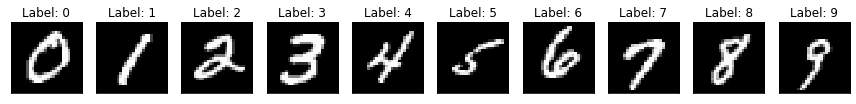

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's try to resize our image to 32 x 32 as asked in the input from the assignment.


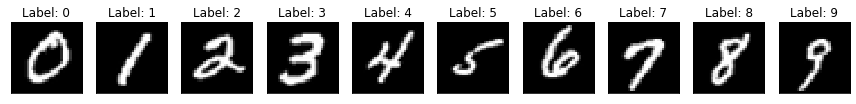

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(cv2.resize(imgs[i-1], dsize=(32,32), interpolation=cv2.INTER_CUBIC),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Looks like it's working good, we will apply it on a function to prepare datasets.
### Load USPS dataset

Let's now load the USPS dataset, unfortunately keras does not have the dataset, so we load it with torchvision which is in another format. This time, each image as a size of 16x16. We need again to transform it to a 32x32x1 shape.


In [0]:
from torchvision import datasets
train_usps = datasets.USPS(root='content/',download=True,train=True)
test_usps = datasets.USPS(root='content/',download=True,train=False)

In [0]:
data = train_usps
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(data)):
    if not data[i][1] in labels and data[i][1] ==j:
      labels.append(data[i][1])
      imgs.append(data[i][0])
      j+=1

Print a sample for each digits.

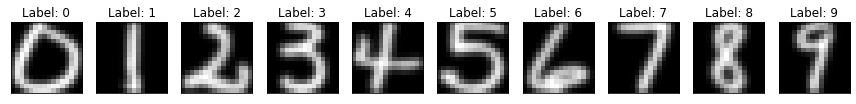

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's reshape again this 16x16 imgs to 32x32

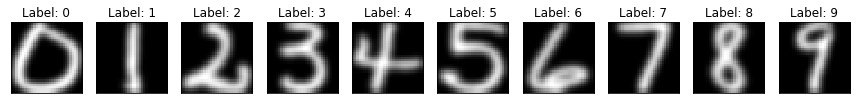

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1].resize((32,32)),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

## Prepare datasets loader

Here is three functions to prepare datatets.

In [0]:
def prepare_mnist_tensor(BATCH_SIZE):
  #Load dataset
  (train_img,_),(test_mnist,_) = mnist.load_data()
  #Reshape img
  train_img = train_img.reshape(train_img.shape[0],train_img.shape[1],train_img.shape[2],1)
  #empty array of shape MNIST[0],32,32 to store img
  t = np.empty((train_img.shape[0],32,32))
  for i in range(train_img.shape[0]):
    t[i] = cv2.resize(train_img[i], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
  #Reshape to a MNIST_train[0],32,32,1 shape
  t = t.reshape(train_img.shape[0],32,32,1)
  train_img = t.astype('float32')
  #normalize data
  train_img = (train_img -127.5)/127.5
  return tf.data.Dataset.from_tensor_slices(train_img).shuffle(train_img.shape[0]).batch(BATCH_SIZE)

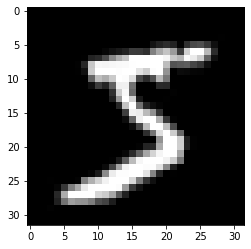

In [0]:
plt.imshow(t[0],cmap='gray',interpolation='none')

In [0]:
def prepare_mnist_cycleGAN(BATCH_SIZE,BUFFER_SIZE=1000):
  #Load data
  (train_img,_),(test_img,_) = mnist.load_data()
  #train_set
  train_img = train_img.reshape(train_img.shape[0],train_img.shape[1],train_img.shape[2],1)
  t = np.empty((train_img.shape[0],32,32))
  for i in range(train_img.shape[0]):
    t[i] = cv2.resize(train_img[i], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
  t = t.reshape(train_img.shape[0],32,32,1)
  train_img = t.astype('float32')
  train_img = (train_img -127.5)/127.5
  #test_set
  test_img = test_img.reshape(test_img.shape[0],test_img.shape[1],test_img.shape[2],1)
  t = np.empty((test_img.shape[0],32,32))
  for i in range(test_img.shape[0]):
    t[i] = cv2.resize(test_img[i], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
  #Reshape to good format
  t = t.reshape(test_img.shape[0],32,32,1)
  #Normalize
  test_img = t.astype('float32')
  test_img = (test_img -127.5)/127.5
  # Prepare two batchdataset
  return tf.data.Dataset.from_tensor_slices(train_img).shuffle(BUFFER_SIZE).batch(BATCH_SIZE),tf.data.Dataset.from_tensor_slices(test_img).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
train_mnist,test_mnist = prepare_mnist_cycleGAN(1,BUFFER_SIZE=1000)

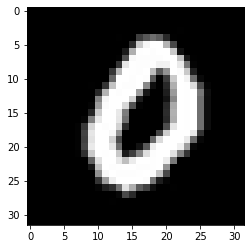

In [0]:
for batch in train_mnist:
  plt.imshow(batch[0,:,:,0],cmap='gray',interpolation='none')
  break

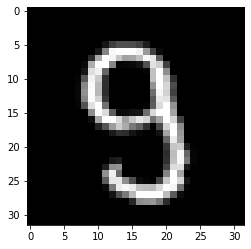

In [0]:
for batch in test_mnist:
  plt.imshow(batch[0,:,:,0],cmap='gray',interpolation='none')
  break

In [0]:
def prepare_usps_cycleGAN(BATCH_SIZE,BUFFER_SIZE=1000):
  from torchvision import datasets
  #Load datasets
  train_usps = datasets.USPS(root='content/',download=True,train=True)
  test_usps = datasets.USPS(root='content/',download=True,train=False)
  #Transform trainset
  t = np.empty((len(train_usps),32,32,1))
  for i in range(len(train_usps)):
    t[i] = np.array(train_usps[i][0].resize((32,32)),dtype='float32').reshape((32,32,1))
  train_usps = t.astype('float32')
  train_usps = (train_usps-127.5)/127.5
  #transform testset
  t = np.empty((len(test_usps),32,32,1))
  for i in range(len(test_usps)):
    t[i] = np.array(test_usps[i][0].resize((32,32)),dtype='float32').reshape((32,32,1))
  test_usps = t.astype('float32')
  test_usps = (test_usps-127.5)/127.5
  return tf.data.Dataset.from_tensor_slices(train_usps).shuffle(BUFFER_SIZE).batch(BATCH_SIZE),tf.data.Dataset.from_tensor_slices(test_usps).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
train_usps,test_usps = prepare_usps_cycleGAN(1,BUFFER_SIZE=1000)

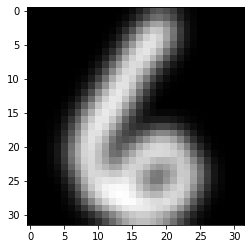

In [0]:
for batch in train_usps:
  plt.imshow(batch[0,:,:,0],cmap='gray',interpolation='none')
  break

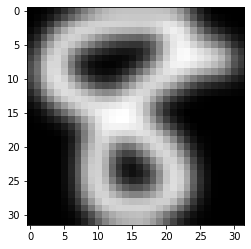

In [0]:
for batch in test_usps:
  plt.imshow(batch[0,:,:,0],cmap='gray',interpolation='none')
  break

# Part 1: Deep Convolutional GAN (DCGAN)

In the first part, the assignment ask to implement the DCGAN.
We will follow this blueprint : 

* Create discriminator

* Create generator

* Create the training procedure


## Discriminator

We have to reproduce this architecture : 


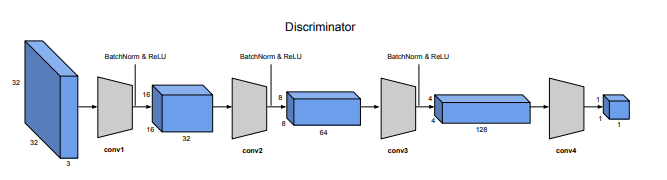

In [3]:
def dis_model(input_shape=(32,32,1)):
  init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
  padding = 'same'
  kernels = (4,4)
  strides = (2,2)
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Conv2D(64,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Conv2D(128,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model
dis_model((32,32,1)).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         2

Taking our initial shape, we got the following model for our discriminator.

## Generator

Let's now try to make the generator model. The representation is : 

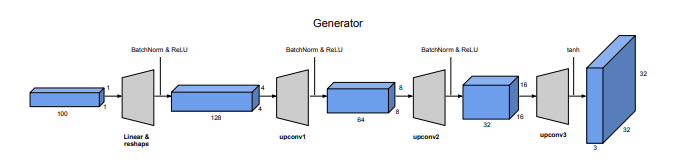

Since we have only 28x28 images, we delete one layer

In [4]:
def gen_model():
    init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*64, use_bias=False, input_shape=(100,),kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 64)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init,activation='tanh'))
    model.summary()
    return model
gen_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102400    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         204800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 4, 128)        

Let's just try to print some generated pictures for the untrained model. Yet it is only random noise pictures.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_12 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 4, 4, 128)         819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4, 4, 128)        

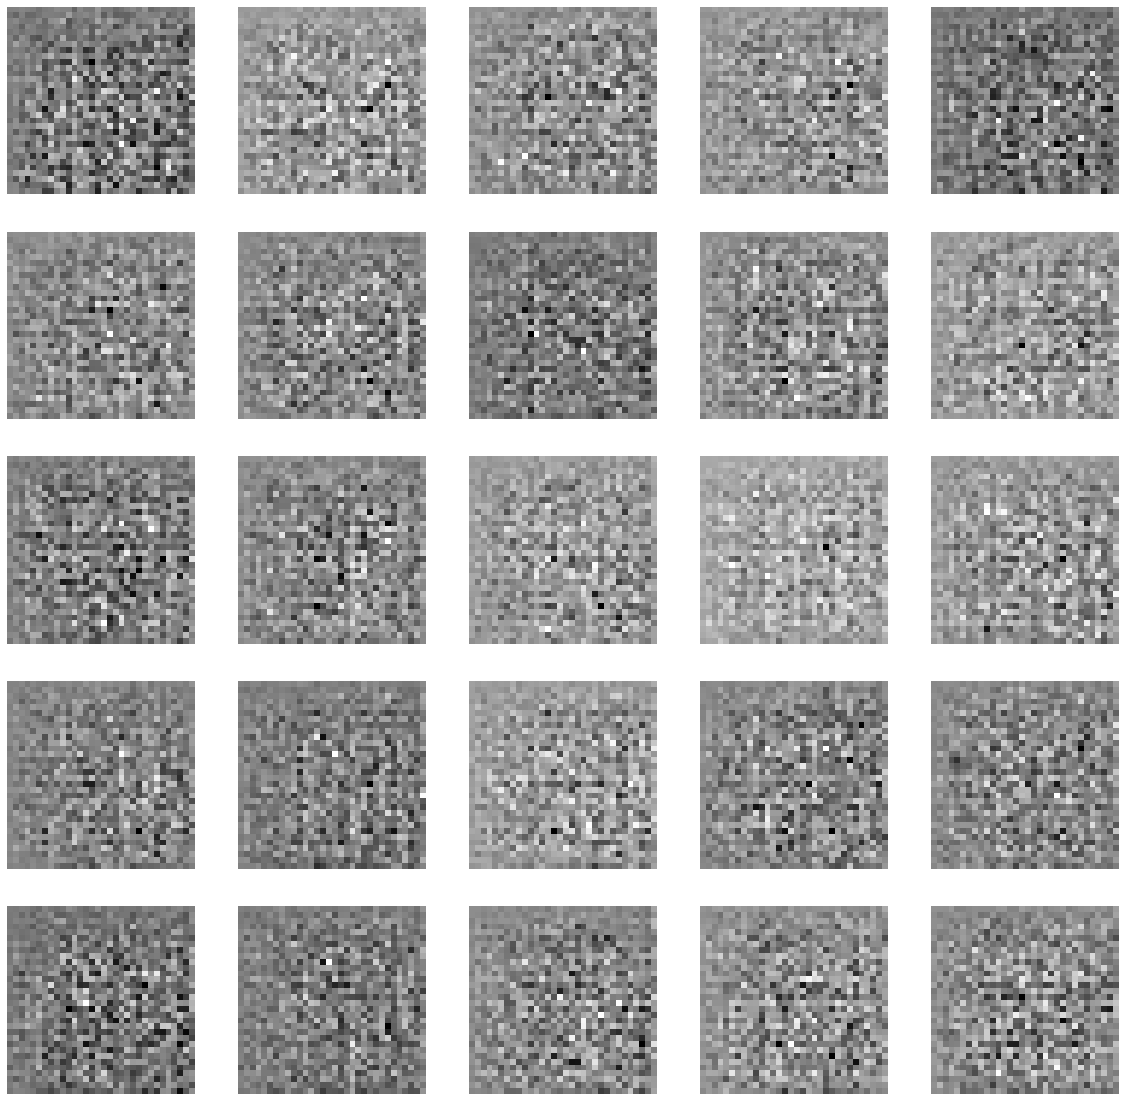

In [0]:
gen = gen_model()
noise = tf.random.normal([25, 100])
gen.training=False
X = gen(noise)
plt.figure(figsize=(20,20))
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(X[i, :, :, 0], cmap='gray_r')

## Training Loop


Here is a representation of the untrained generator. First we have to load the generator and the discriminator, then load the dataset.

In [5]:
dataset = prepare_mnist_tensor(256)

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
discriminator = dis_model()
generator = gen_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              102400    
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 128)         204800    
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4, 4, 128)        

We need to define our parameters now : 

* Number of EPOCHS

* The total BATCH_SIZE

We also need to take one optimizer for each model. We take the Adam optimizer which is the one used in the paper.

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
EPOCHS = 500
noise_dim = 100
examples = 25
BATCH_SIZE = 256
seed = tf.random.normal([examples, 100])

We have now to define our two loss, one for each model.

The discriminator loss is based on two loss, the real loss which is the binary cross entropy for real data and the fake loss which is the loss for fake data.

The generator loss is just the loss of the fake ouptput.

In [0]:
def discriminator_loss(real, fake):
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)
    real_loss = cross_entropy(tf.ones_like(real), real)
    return real_loss + fake_loss
def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

Now we create a tensorflow function for a train step for models on batch. 

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #Generate a number of image 
      generated_images = generator(noise, training=True)
      #take the image of batch and pass it through the discriminator
      real_output = discriminator(images, training=True)
      #Same thing with generated images
      fake_output = discriminator(generated_images, training=True)
      #Calculate both loss
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    #Pass models through gradients with adam optimizer
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    #Return both loss
    return gen_loss,disc_loss

Create the main train loop.


In [0]:
def train(dataset, epochs):
  from IPython import display
  # List to store loss of models for each epoch
  global_loss_gen = []
  global_loss_disc = []
  for epoch in range(epochs):
    start = time.time()
    loss_gen = []
    loss_disc = []
    #For each batch on datasetbatch we train
    for image_batch in dataset:
      (g,d) = train_step(image_batch)
      loss_gen.append(g),loss_disc.append(d)
    #append mean loss for each
    global_loss_gen.append(np.mean(loss_gen)),global_loss_disc.append(np.mean(loss_disc))
    display.clear_output(wait=True)
    #Generate img
    generate_images(generator,epoch + 1,seed)
    print(f'Generator loss : {np.mean(loss_gen)}\nDiscriminator loss : {np.mean(loss_disc)}')
    print (f'Time for epoch {epoch + 1} is {time.time()-start} sec')
    plt.figure(figsize=(12,12))
    plt.plot(range(len(global_loss_gen)),global_loss_gen,color='blue')
    plt.plot(range(len(global_loss_disc)),global_loss_disc,color='red')
    plt.show()
  display.clear_output(wait=True)
  #Generate the last output of the model
  generate_images(generator,epochs,seed)
  plt.figure(figsize=(12,12))
  plt.plot(range(len(global_loss_gen)),global_loss_gen,color='blue')
  plt.plot(range(len(global_loss_disc)),global_loss_disc,color='red')
  plt.savefig('final.png')
  plt.show()

Here is a function to print the output of the generator at a defined epoch.

In [0]:
def generate_images(model, epoch, test_input):
  pred= model(test_input, training=False)
  fig = plt.figure(figsize=(16,16))
  for i in range(pred.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(pred[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.suptitle(f"Epoch : {epoch}", fontsize=14)
  #Save the 5x5 plot to create a GIF after it
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

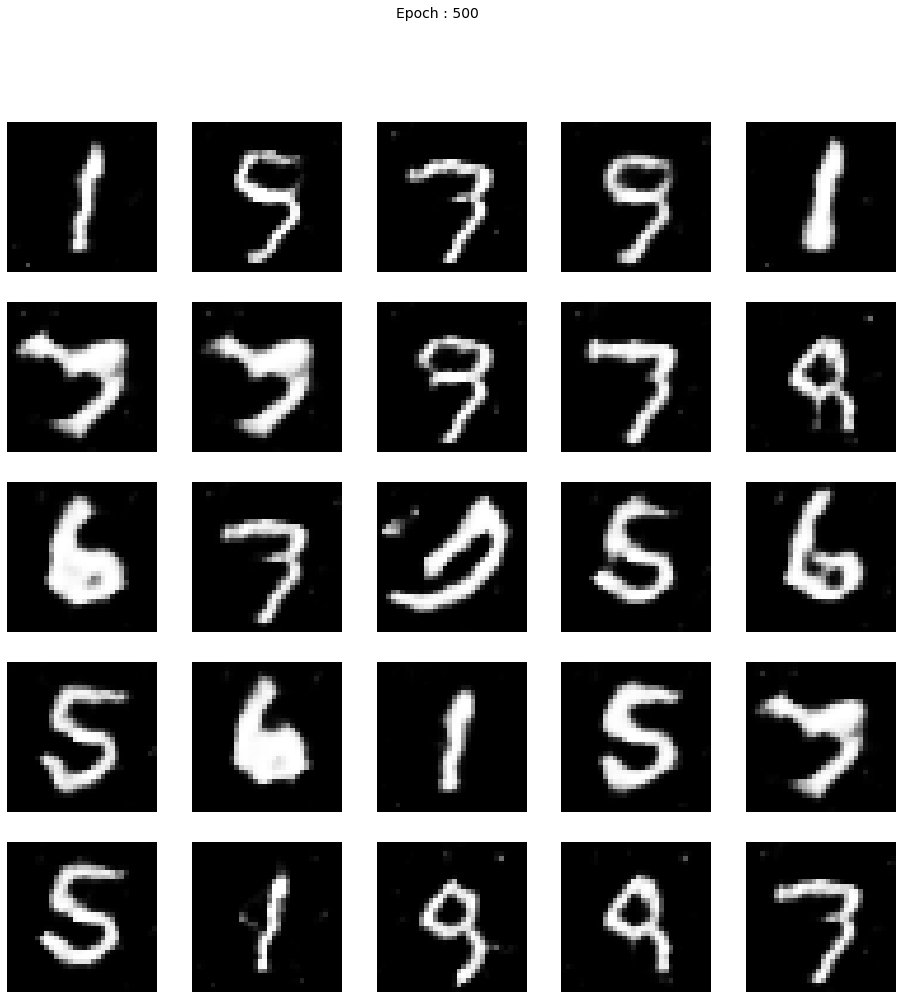

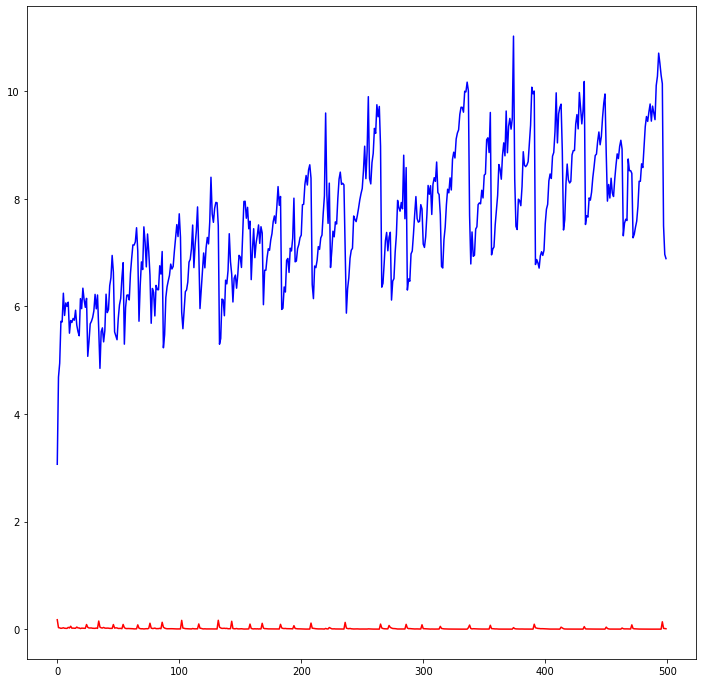

In [12]:
train(dataset, EPOCHS)

Let's now create a gif of each epoch

In [0]:
def create_gif(filename,img_start_with):
  import imageio
  import glob
  anim_file = f'{filename}.gif'
  with imageio.get_writer(anim_file, mode='I',duration='0.5') as writer:
    filenames = glob.glob(f'{img_start_with}*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
      frame = 2*(i**0.5)
      if round(frame) > round(last):
        last = frame
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download(anim_file)

With the GIF we clearly see that the model is learning step by step. At the beginning we got white noise while with 500 epochs we got a pretty good output which looks like MNIST digits

In [0]:
create_gif('GAN',"image")

# Part 2 : Cycle GAN

We will now create the Cycle Gan generator. This time, we will only rebuild a generator on a different architecture. We will use only one resnet block (which is two Conv2D block with a concatenation of the output of this block with the input of the resnet.

### Cycle Gan Generator

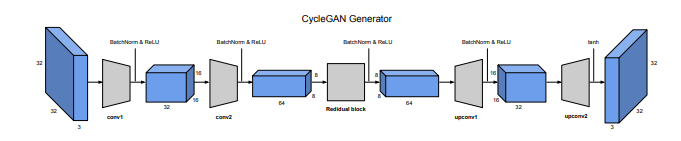

In [0]:
def generator_cycle_gan(input_shape=(32,32,1)):
  init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
  #Encoder
  Input_img = Input(shape=(32,32,1))
  conv1 = Conv2D(32,(5,5),strides=(2,2),padding='same',kernel_initializer = init)(Input_img)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)
  conv2 = Conv2D(64,(5,5),strides=(2,2),padding='same',kernel_initializer = init)(conv1)
  conv2 = BatchNormalization()(conv2)
  conv2 = Activation('relu')(conv2) 
  #Resnet 
  resnet1 = Conv2D(64,(5,5),strides = (1,1),padding='same',kernel_initializer=init)(conv2)
  resnet1 = BatchNormalization()(resnet1)
  resnet1 = Activation('relu')(resnet1)
  resnet2 = Conv2D(64,(5,5),strides = (1,1),padding='same',kernel_initializer=init)(resnet1)
  resnet2 = BatchNormalization()(resnet2)
  resnet2 = Activation('relu')(resnet2)
  resnet_out = Concatenate()([resnet2,conv2])
  #Decoder
  deconv1 = Conv2DTranspose(32,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(resnet_out)
  deconv1 = BatchNormalization()(deconv1)
  deconv1 = Activation('relu')(deconv1)
  out = Conv2DTranspose(1,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(deconv1)
  out = Activation('tanh')(out)
  model = Model(Input_img,out)
  model.summary()
  return model
generator_cycle_gan()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 16, 16, 32)   128         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 32)   0           batch_normalization_3[0][0]      
______________________________________________________________________________________________

This time we load the data on batch of one picture. The model we be train one image by one.

In [0]:
train_mnist,test_mnist = prepare_mnist_cycleGAN(1)
train_usps,test_usps = prepare_usps_cycleGAN(1)

In [0]:
sample_mnist = next(iter(train_mnist))
sample_usps = next(iter(train_usps))

Just get some sample to compare with the generator after the training.

In [0]:
train_mnist_sample = []
i=0
for batch in train_mnist:
  i+=1
  train_mnist_sample.append(batch)
  if i >= 7:
    break

Load the model. We have two generator and discriminator in order to respect the image below. It is used for MNIST to USPS image translation.

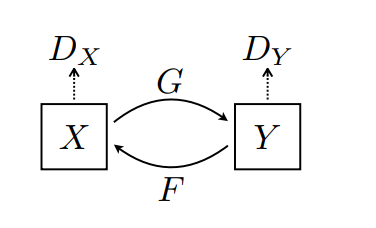

In [0]:
generator_g = generator_cycle_gan((32,32,1))
generator_f = generator_cycle_gan((32,32,1))
discriminator_x = dis_model((32,32,1))
discriminator_y = dis_model((32,32,1))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 16, 16, 32)   128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 16, 16, 32)   0           batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [0]:
to_usps = generator_g(sample_mnist)
to_mnist = generator_f(sample_usps)

Yet if we apply our generator F a sample_usps image to transform it to MNIST. Yet because the generator is untrained we only got noise

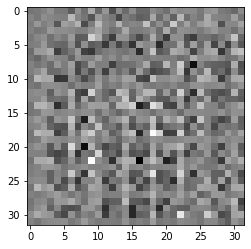

In [0]:
plt.imshow(to_mnist[0,:,:,0],cmap='gray')

Same thing, but we had the original input.

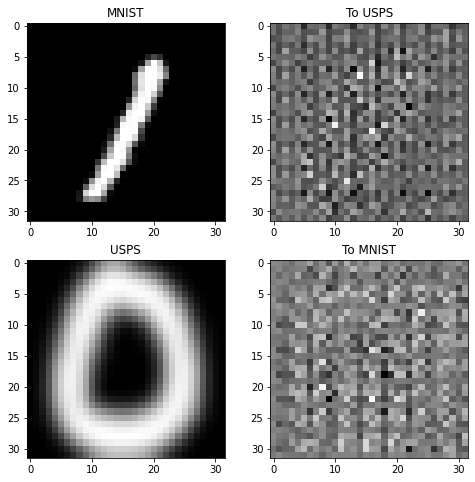

In [0]:
plt.figure(figsize=(8, 8))
contrast = 8
imgs = [sample_mnist, to_usps, sample_usps, to_mnist]
title = ['MNIST', 'To USPS', 'USPS', 'To MNIST']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0,:,:,0]* 127.5 + 127.5,cmap='gray')
  else:
    plt.imshow(imgs[i][0,:,:,0]* 127.5 + 127.5,cmap='gray')
plt.show()

We once again define the loss for each model plus the cycle gan loss. It is again based on binary cross entropy.

In [0]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real, fake):
  real_loss = crossEntropy(tf.ones_like(real),real)
  fake_loss = crossEntropy(tf.ones_like(fake),fake)
  total = real_loss+fake_loss
  return total *0.5
def generator_loss(fake):
  return crossEntropy(tf.ones_like(fake),fake)
def cycle_gan_loss(real,cycled):
  loss = tf.reduce_mean(tf.abs(real-cycled))
  return loss * 10
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return 10 * 0.5 * loss

We load our four models for the cycle gan iteration

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

We use a low number of epoch because we are travelling through our dataset one image per image. So the process is very slow.

In [0]:
EPOCHS = 10

In [0]:
def generate_images(model, test_input,epoch):
  predictions=[]
  for i in range(len(test_input)):
    predictions.append(model(test_input[i]))
  plt.figure(figsize=(12, 12))
  k=0
  l=0
  for i in range(1,5):
    if i % 2 == 1:
      for j in range(0,12,4):
        plt.subplot(3,4,i+j)
        plt.title("Real MNIST image")
        plt.imshow(test_input[k][0,:,:,0],cmap='gray')
        k+=1
    else:
      for j in range(0,12,4):
        plt.subplot(3,4,i+j)
        plt.title("Predicted image with USPS style")
        plt.imshow(predictions[l][0,:,:,0],cmap='gray')
        l+=1
  plt.suptitle(f'epoch {epoch}')
  plt.savefig(f'cyclegan_at_epoch_{epoch}.png')
  plt.show()

Without training the generator, here is the output we get.

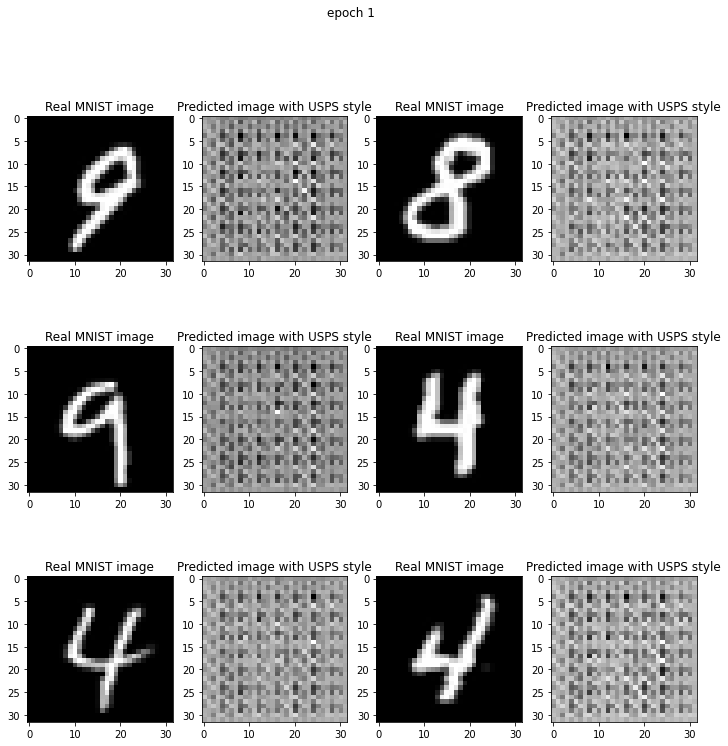

In [0]:
generate_images(generator_g, train_mnist_sample,1)

Once again, we define a tensorflow function for the train step

In [0]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    generator_g.trainable=True
    generator_f.trainable=True
    discriminator_x.trainable=True
    discriminator_y.trainable=True
    fake_y = generator_g(real_x)
    cycled_x = generator_f(fake_y)
    fake_x = generator_f(real_y)
    cycled_y = generator_g(fake_x)
    same_x = generator_f(real_x)
    same_y = generator_g(real_y)
    disc_real_x = discriminator_x(real_x)
    disc_real_y = discriminator_y(real_y)
    disc_fake_x = discriminator_x(fake_x)
    disc_fake_y = discriminator_y(fake_y)
    # Loss of generator's model
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    #total loss
    total_cycle_loss = cycle_gan_loss(real_x, cycled_x) + cycle_gan_loss(real_y, cycled_y)
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    #discriminator loss
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Let's now try the cycle gan model !!!

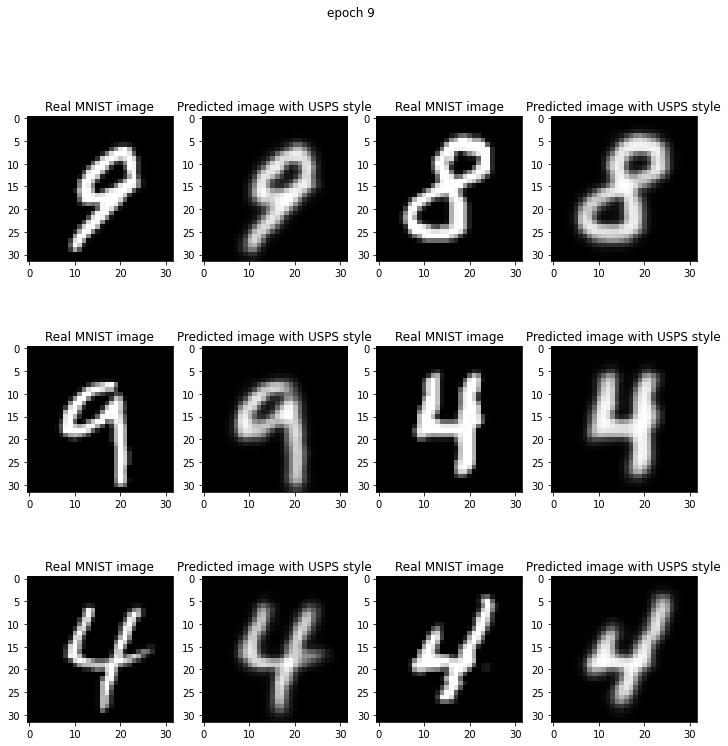

Time taken for epoch 10 is 229.3394341468811 sec



In [0]:
from IPython import display
for epoch in range(EPOCHS):
  start = time.time()
  for image_x, image_y in zip(train_mnist, train_usps):
    train_step(image_x, image_y)
  display.clear_output(wait=True)
  generate_images(generator_g, train_mnist_sample,epoch)
  print (f'Time taken for epoch {epoch + 1} is {time.time()-start} sec\n')

Create a gif of our 10 epochs

In [0]:
create_gif('cyclegan',"cyclegan")

We will now try the model on the test dataset. It seems that the generator is pretty good trained. We got a nice output.

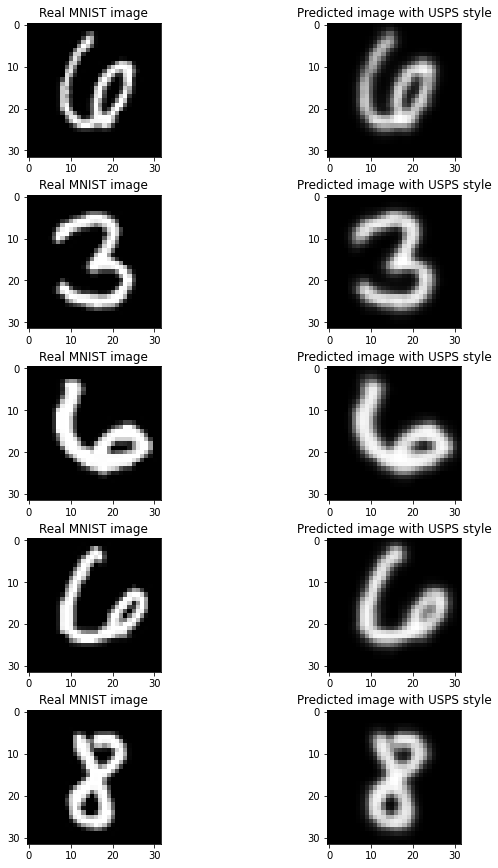

In [0]:
plt.figure(figsize=(12, 12))
j=1
for batch,i in zip(test_mnist,range(1,6)):
  predictions=generator_g(batch)
  plt.subplot(5,2,j)
  plt.title("Real MNIST image")
  plt.imshow(batch[0,:,:,0],cmap='gray')
  plt.subplot(5,2,j+1)
  plt.title("Predicted image with USPS style")
  plt.imshow(predictions[0,:,:,0],cmap='gray')
  j+=2
  plt.tight_layout(0.5)
plt.show()



Bibliographic help :

* [training loop construction](https://www.tensorflow.org/tutorials/generative/dcgan) 
